In [ ]:
import pandas as pd                   
import numpy as np                    
from math import sqrt                
from pandas import Series            
from matplotlib import pyplot         
from matplotlib.pyplot import figure  
import matplotlib.pyplot as plt       
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k') 
from matplotlib.pylab import rcParams 
import statsmodels.api as sm          
import statsmodels.tsa.api as smt     
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt  
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller # mengakses function Augmented Dickey-Fuller unit root test. 
from statsmodels.tsa.arima_model import ARIMA  # mengakses function ARIMA
import statsmodels.formula.api as smf # digunakan untuk menentukan model dengan formula strings dan DataFrames.
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 

from datetime import datetime         
import warnings                       # built-in modul untuk menghandle message dari issue warning, jika ada package yg obsolete
warnings.filterwarnings('ignore')    
import sys                            
import itertools                      
import seaborn as sns               
%matplotlib inline   

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


EXPLORATORY DATA ANALYSIS


---



---



---




In [ ]:
#import data
data1 = pd.read_csv("/content/drive/MyDrive/00_CHECKPOINT3/join.csv")
profit = pd.read_csv ("/content/drive/MyDrive/00_CHECKPOINT3/revenue_name.csv")  #data yang menghasilkan profit sudah difilter yang statusnya complete saja 

In [ ]:
#Cek missing value
data1.isna().sum()

id                   0
user_id              0
product_id           0
status               0
created_at           0
shipped_at       63006
delivered_at    117473
returned_at     162756
cost                 0
sale_price           0
state                0
dtype: int64

In [ ]:
profit.isna().sum()

delivered_at    0
state           0
user_id         0
product_id      0
id              0
revenue         0
name            2
dtype: int64

In [ ]:
## Drop rows pada kolom city yang bernilai null
profit=profit.dropna(subset=['name'])

In [ ]:
#ubah tipe data
data1['created_at'] = pd.to_datetime(data1['created_at'], infer_datetime_format=True)
data1['shipped_at'] = pd.to_datetime(data1['shipped_at'], infer_datetime_format=True)
data1['delivered_at'] = pd.to_datetime(data1['delivered_at'], infer_datetime_format=True)
data1['returned_at'] = pd.to_datetime(data1['returned_at'], infer_datetime_format=True)
profit['delivered_at']= pd.to_datetime(profit['delivered_at'], infer_datetime_format=True)

In [ ]:
#membaca data
data1.head()

,id,user_id,product_id,status,created_at,shipped_at,delivered_at,returned_at,cost,sale_price,state
0,1,1,16783,Complete,2019-07-20,2019-07-18,2019-07-22,NaT,28.325000,55.000000,Gyeonggi-do
1,2,1,21357,Complete,2019-07-21,2019-07-18,2019-07-22,NaT,35.095548,68.949997,Gyeonggi-do
2,3,1,26458,Complete,2019-07-20,2019-07-18,2019-07-22,NaT,5.515400,11.990000,Gyeonggi-do
3,4,1,27726,Complete,2019-07-19,2019-07-18,2019-07-22,NaT,28.294341,49.990002,Gyeonggi-do
4,5,1,27061,Processing,2021-11-30,NaT,NaT,NaT,17.430000,42.000000,Gyeonggi-do


In [ ]:
#Total status order 
status_order=(data1.id).groupby(data1.status).count()
status_order

status
Cancelled     26781
Complete      45283
Processing    36225
Returned      17752
Shipped       54467
Name: id, dtype: int64

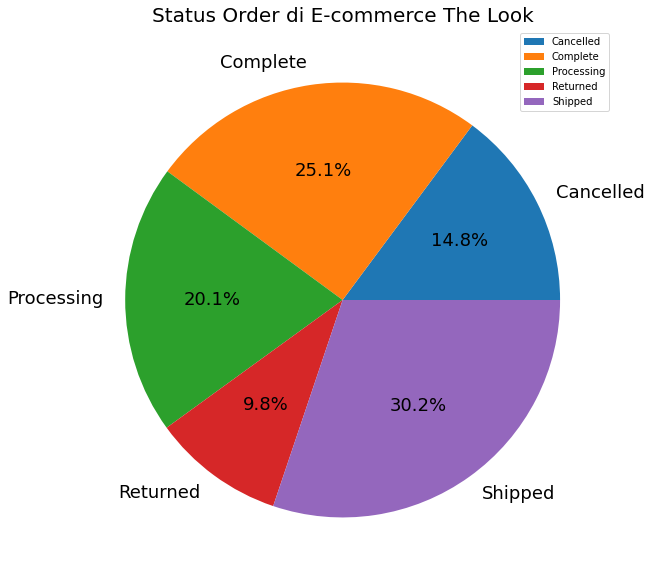

In [ ]:
#Visualisasi Total status order 
plt.figure(figsize=(10,10))
plt.pie((status_order), 
        labels=['Cancelled','Complete','Processing','Returned','Shipped'],
        autopct='%.1f%%',textprops={'color':"black", "fontsize":18})
plt.title('Status Order di E-commerce The Look', fontsize=20)
plt.legend()
plt.show()

In [ ]:
data1[['year']] = pd.DataFrame(data1.created_at.dt.year)

In [ ]:
#Traffic penjualan pertahun
traffic=(data1.id).groupby(data1.year).count().reset_index()
traffic

,year,id
0,2019,8170
1,2020,30278
2,2021,70879
3,2022,71181


Text(0.5, 1.0, 'Jumlah Traffic Penualan Per Tahun')

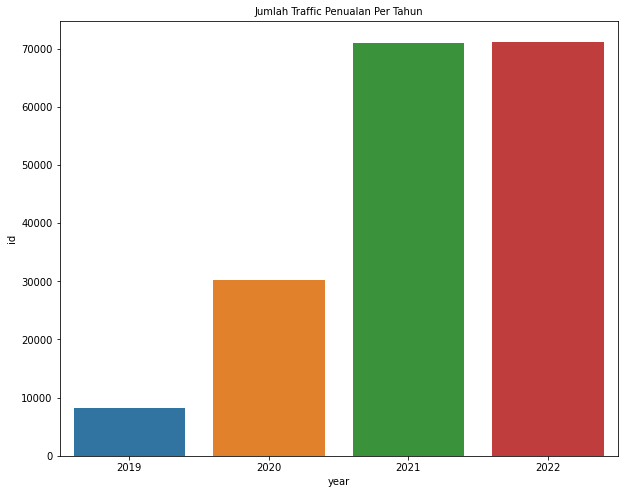

In [ ]:
#Visualisasi Traffic penjualan pertahun
plt.figure(figsize=(10,8))
sns.barplot(x='year',y='id', data=traffic)
plt.title('Jumlah Traffic Penualan Per Tahun', fontsize=10)

In [ ]:
#Top 10 product_id dengan penjualan tertinggi 
product_jumlah = data1.groupby(['product_id'],as_index=False)['id'].count()
top_product =  product_jumlah.sort_values(by='id',ascending=False)
product_id  = pd.DataFrame(top_product).head(10)
product_id

,product_id,id
22482,22544,20
18891,18952,20
22662,22724,19
16971,17032,18
25982,26050,18
17249,17310,18
17145,17206,17
20781,20842,17
26300,26368,17
21412,21474,17


#Visualisasi Traffic penjualan pertahun
plt.figure(figsize=(10,8))
sns.barplot(x='year',y='id', data=traffic)
plt.title('Jumlah Traffic Penualan Per Tahun', fontsize=10)

ANALISIS TERHADAP DATA YANG MENGHASILKAN REVENUE (STATUS_COMPLETE)

In [ ]:
#Menganalisis data yang menghasilkan revenue (Status_Complete)
profit.head()

,delivered_at,state,user_id,product_id,id,revenue,name
0,2019-01-06,Texas,29050,17357,51994,35.177999,Diamond Supply - Mens Supply Co. Hoodie in Black
1,2019-01-06,Texas,29050,25284,51995,7.002000,Polo Ralph Lauren Men's Sport 3-Pair Socks 10-13
2,2019-01-15,California,95675,18164,172504,28.857779,Duofold Men's Mid Weight Single-Layer Thermal ...
3,2019-01-15,California,95675,20518,172505,10.461500,Allegra K Mens Fashion Single Breasted Stretch...
4,2019-01-15,Maryland,33204,19579,59449,38.293000,Paul Fredrick 100% Cotton Solid Cardgian Sweat...


In [ ]:
#Top 10 product_id dengan penjualan tertinggi (Menghasilkan revenue)
product_jumlah = profit.groupby(['name'],as_index=False)['id'].count()
top_product =  product_jumlah.sort_values(by='id',ascending=False)
name  = pd.DataFrame(top_product).head(10)
name

,name,id
21151,Wrangler Men's Cowboy Cut Western Jean,13
12385,Lucky Brand Mens Men's 361 Vintage Straight De...,13
21163,Wrangler Men's Premium Performance Cowboy Cut ...,12
377,7 For All Mankind Men's Standard Classic Strai...,12
10727,Joseph Abboud Men's Two-button Side Vent Sport...,10
457,80s Wayfarer Party Sunglasses W Mustache W168,10
7389,FULL TILT Basic Womens Zip Hoodie,10
16642,Ray-Ban RB3407 Outdoorsman II Sunglasses,10
14513,Nippies Skin - Reusable Natural Looking Ultra ...,10
8640,HANES Over-the-Calf Tube - 10 Pairs - 180/10,9


Text(0.5, 1.0, 'Top 10 Product_Id dengan Jumlah Penjualan Tertinggi')

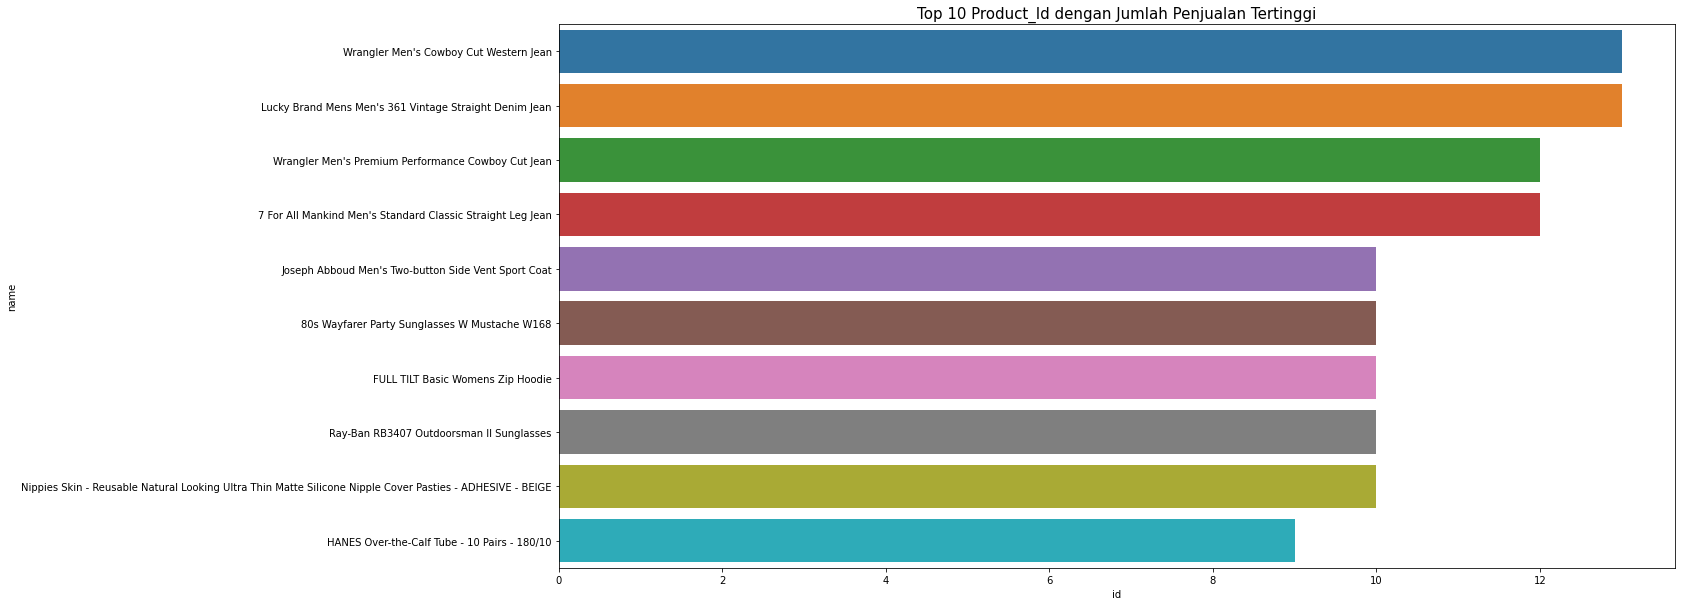

In [ ]:
#Visualisasi Top 5 product_id dengan penjualan tertinggi (Menghasilkan revenue)
plt.figure(figsize=(20,10))
sns.barplot(x='id',y='name', data=name)
plt.title('Top 10 Product_Id dengan Jumlah Penjualan Tertinggi', fontsize=15)

In [ ]:
#Top 10 User_id yang memberi revenue tertinggi pada e-commerce
user_revenue = profit.groupby(['user_id'],as_index=False)['revenue'].sum()
top_user = user_revenue.sort_values(by='revenue',ascending=False)
user_id = pd.DataFrame(top_user).head(10)
user_id


,user_id,revenue
8180,30086,665.484999
14833,53961,651.673413
4818,17616,632.639087
24389,88319,619.135199
5411,19846,607.210689
2846,10415,603.958048
8648,31824,593.252505
1651,5924,587.566680
24565,88999,582.626678
5189,19003,579.263999


Text(0.5, 1.0, 'Top 10 User_Id dengan Revenue Tertinggi')

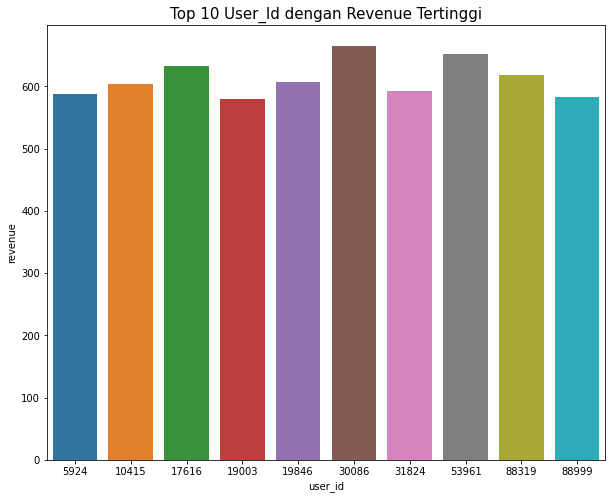

In [ ]:
#Visualisasi Top 10 User_id yang memberi revenue tertinggi pada e-commerce
plt.figure(figsize=(10,8))
sns.barplot(x='user_id',y='revenue', data=user_id)
plt.title('Top 10 User_Id dengan Revenue Tertinggi', fontsize=15)

In [ ]:
#Top 10 state yang memberi revenue tertinggi pada e-commerce
state_revenue = profit.groupby(['state'],as_index=False)['revenue'].sum()
top_state = state_revenue.sort_values(by='revenue',ascending=False)
state = pd.DataFrame(top_state).head(10)
state

,state,revenue
66,Guangdong,75651.445080
52,England,54139.371718
28,California,52888.228543
187,Shanghai,36832.042345
198,Texas,36744.580564
20,Beijing,29975.340454
195,São Paulo,28906.963280
221,Zhejiang,28131.169891
78,Hebei,25578.843427
56,Florida,25102.164443


Text(0.5, 1.0, 'Top 10 State dengan Revenue Tertinggi')

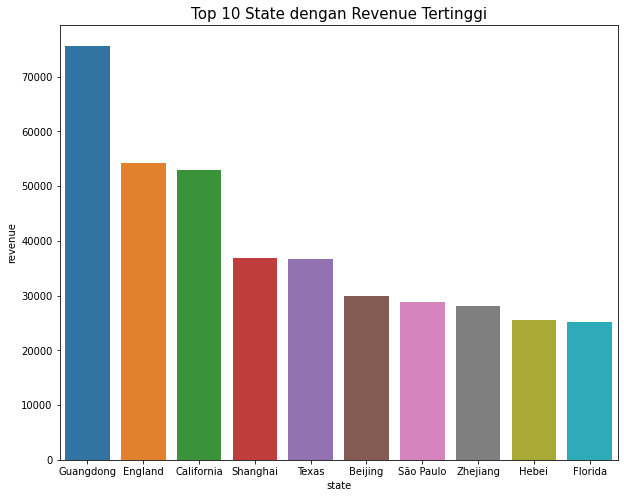

In [ ]:
#Visualisasi Top 10 state yang memberi revenue tertinggi pada e-commerce
plt.figure(figsize=(10,8))
sns.barplot(x='state',y='revenue', data=state)
plt.title('Top 10 State dengan Revenue Tertinggi', fontsize=15)

DATA PREPARATION - TIME SERIES FORECASTING - WAKTU TERHADAP REVENUE

In [ ]:
analisis = pd.read_csv("/content/drive/MyDrive/00_CHECKPOINT3/revenue_revisi.csv") #data yang akan digunakan prediksi revenue di time series forecasting
analisis

,delivered_at,revenue
0,2019-01-06,42.179999
1,2019-01-15,77.612279
2,2019-01-18,9.636000
3,2019-01-24,83.275519
4,2019-01-29,40.239918
...,...,...
1198,2022-06-06,6319.029900
1199,2022-06-07,3865.463001
1200,2022-06-08,1159.991733
1201,2022-06-09,409.467242


In [ ]:
analisis['delivered_at']= pd.to_datetime(analisis['delivered_at'], infer_datetime_format=True)

In [ ]:
#mengubah datetime menjadi index
analisis = analisis.set_index('delivered_at')
analisis

,revenue
delivered_at,
2019-01-06,42.179999
2019-01-15,77.612279
2019-01-18,9.636000
2019-01-24,83.275519
2019-01-29,40.239918
...,...
2022-06-06,6319.029900
2022-06-07,3865.463001
2022-06-08,1159.991733


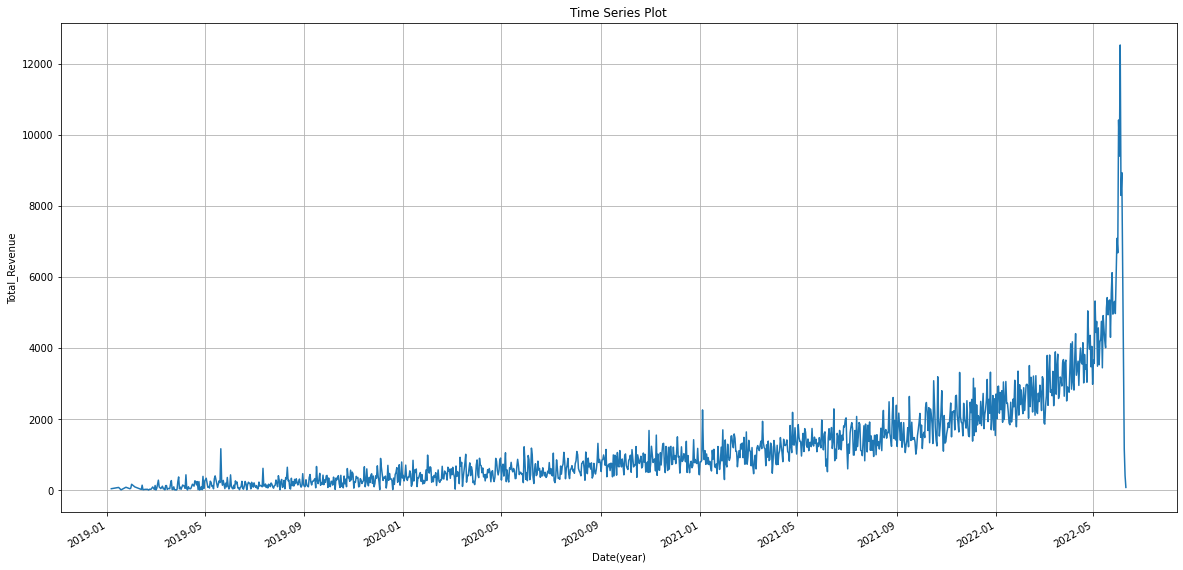

In [ ]:
# Time Series plot

import matplotlib.dates as mdates
import matplotlib.pyplot as plty

fig, ax = plty.subplots(figsize=(20,10))
plty.xlabel("Date(year)")
plty.ylabel("Total_Revenue")
plt.title('Time Series Plot' )

half_year_locator = mdates.MonthLocator(interval = 4)
year_month_formatter = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(analisis)
fig.autofmt_xdate()
plty.grid()
plty.show()


CHECK POINT 4 MODELLING

---



---



In [ ]:
#Memanggil data 
data=pd.read_csv('/content/drive/MyDrive/00_Pagi/salinan_sales.csv')

# Melihat jumlah baris dan kolom
data.shape

(40, 2)

In [ ]:
# Menampilkan 5 baris terakhir pada dataframe (default n = 5)
data.tail() 

,month,total_sales
35,2022-01-01 00:00:00,9672
36,2022-02-01 00:00:00,9616
37,2022-03-01 00:00:00,12235
38,2022-04-01 00:00:00,13944
39,2022-05-01 00:00:00,23599


###3 Data Exploration



In [ ]:
# Menampilkan nama kolom 
data.columns 

Index(['month', 'total_sales'], dtype='object')

In [ ]:
# Menampilkan info dari tiap variable
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month        40 non-null     object
 1   total_sales  40 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 768.0+ bytes


In [ ]:
# Pada kolom Month, ubah tipe data menjadi datetime
data['month']=pd.to_datetime(data['month'], infer_datetime_format=True)

# Cek tipe data 
print (data.dtypes)

month          datetime64[ns]
total_sales             int64
dtype: object


> Ketika *dealing* dengan data time series, dianjurkan untuk menggunakan kolom yang mengandung 'date' sebagai index dari dataframe.

In [ ]:
# Set kolom 'Month' sebagai index
data=data.set_index(['month'])
data.tail()

,total_sales
month,
2022-01-01,9672
2022-02-01,9616
2022-03-01,12235
2022-04-01,13944
2022-05-01,23599


In [ ]:
data.head()

,total_sales
month,
2019-02-01,113
2019-03-01,241
2019-04-01,403
2019-05-01,521
2019-06-01,558


In [ ]:
# Summary statistics pada variabel '#Passengers'
print (data.describe().T)
print ('---------')

# Pembulatan decimal 2 angka di belakang koma
print(data.describe().T.round(2))

             count     mean          std    min      25%     50%      75%  \
total_sales   40.0  4466.95  4604.584176  113.0  1299.25  3065.0  6059.25   

                 max  
total_sales  23599.0  
---------
             count     mean      std    min      25%     50%      75%      max
total_sales   40.0  4466.95  4604.58  113.0  1299.25  3065.0  6059.25  23599.0


###4 Data Analysis


#### 4.1 Time Series Plot

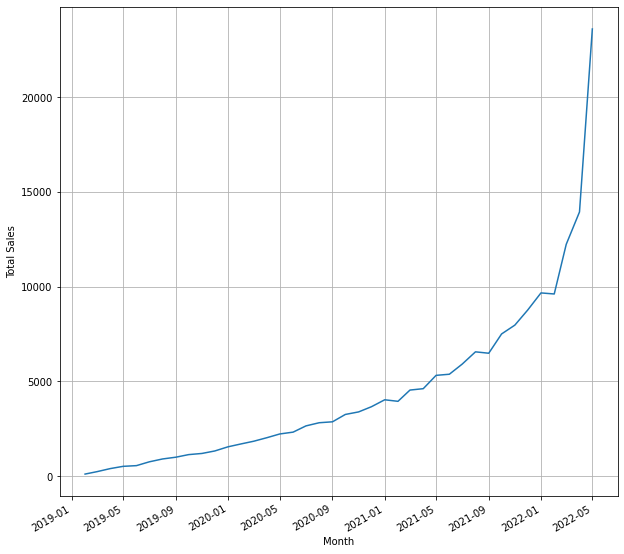

In [ ]:
# Time Series plot

import matplotlib.dates as mdates
import matplotlib.pyplot as plty

fig, ax = plty.subplots(figsize=(10,10))
plty.xlabel("Month")
plty.ylabel("Total Sales")

half_year_locator = mdates.MonthLocator(interval = 4)
year_month_formatter = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(data)
fig.autofmt_xdate()
plty.grid()
plty.show()


> **Insights:**


* Lalu kita coba untuk melihat lebih jelas melalui bantuan package seaborn dan membuat dataframe sementara (variabel: data2) untuk membuat visualisasi seasonal plot.



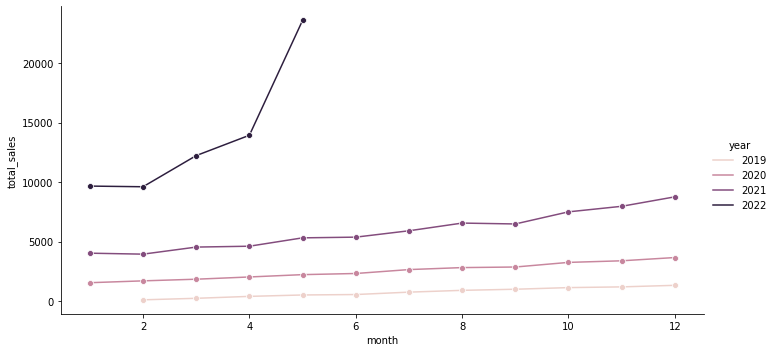

In [ ]:
# Seasonal plot 

data2 = data.reset_index()
data2['year'] = pd.DatetimeIndex(data2['month']).year
data2['month'] = pd.DatetimeIndex(data2['month']).month

# parameter hue digunakan untuk menampilkan multiple line chart berdasarkan tahun ('year')
sns.relplot (kind = 'line', data = data2, x = 'month', y = 'total_sales', hue = 'year', aspect = 2, marker='o' )

* Selanjutnya


---


kita dapat cek secara visual (menggunakan rolling mean & std) dan melakukan uji statistik (statistical test) dengan Dickey-Fuller tes untuk melakukan konfirmasi apakah data yang dimiliki merepresentasikan bentuk stasioner. 

#### 4.2 Stationarity Check - Rolling Statistic test

In [ ]:
# rolling dengan interval window sebesar 3 bulan dan hitung rata-rata
rolmean=data.rolling(window=3).mean()  

# rolling dengan interval window sebesar 3 bulan dan hitung st. deviasi
rolstd=data.rolling(window=3).std() 

# Tampilkan 12 baris pertama dari hasil rolling mean
print('12 baris pertama rolling mean: ')
print(rolmean.head(12))                
print ('')

# Tampilkan 12 baris pertama dari hasil rolling st. deviasi
print('12 baris pertama std. deviasi: ')
print(rolstd.head(12))            

12 baris pertama rolling mean: 
            total_sales
month                  
2019-02-01          NaN
2019-03-01          NaN
2019-04-01   252.333333
2019-05-01   388.333333
2019-06-01   494.000000
2019-07-01   612.666667
2019-08-01   742.333333
2019-09-01   890.666667
2019-10-01  1017.666667
2019-11-01  1114.666667
2019-12-01  1224.333333
2020-01-01  1361.666667

12 baris pertama std. deviasi: 
            total_sales
month                  
2019-02-01          NaN
2019-03-01          NaN
2019-04-01   145.331804
2019-05-01   140.575010
2019-06-01    80.950602
2019-07-01   128.071595
2019-08-01   176.590864
2019-09-01   123.143548
2019-10-01   115.699323
2019-11-01   101.401841
2019-12-01    98.103687
2020-01-01   177.370610


> Lalu, kita akan visualisasikan dari hasil rolling mean dan rolling std. deviasi untuk mengecek apakah apakah series ini stasioner atau tidak melalui bentuk visual grafik di bawah.

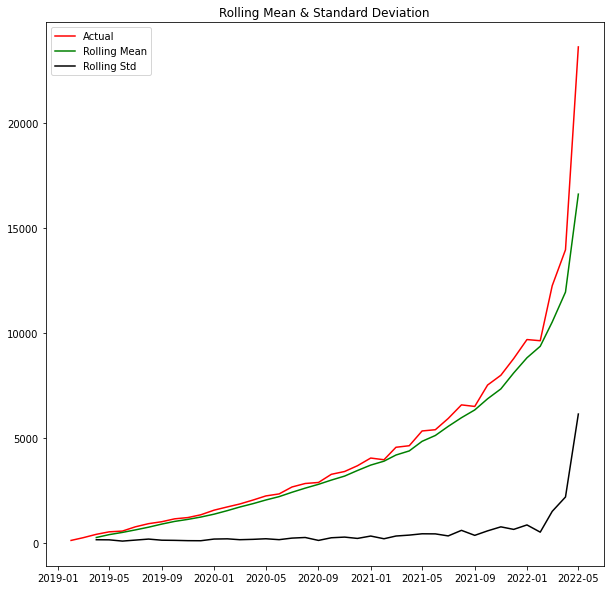

In [ ]:
# atur ukuran chart
plt.figure(figsize=(10,10))

# buat multiple line chart berdasarkan warna dan label
actual=plt.plot(data, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')

# tampilkan legend, judul dari chart, dan panggil function untuk menampilkan chart
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### 4.3 Stationarity Check - Augmented Dickey-Fuller (ADF) test

* Selanjutnya, kita akan gunakan ADF test untuk uji stasioner dimana: 

  **H0:** *The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.*

 **H1:** *The time series is stationary.*

* Jika p-value test kurang dari significance level (contoh alpha = 0.05) dan nilai ADF test lebih kecil dibandingkan critical values maka kita dapat reject null hypothesis dan dapat menyimpulkan bahwa time series adalah stasioner.

In [ ]:
# menggunakan function adfuller() yang diterapkan pada variable #total_sales
print('Dickey-Fuller Test: ')
dftest=adfuller(data['total_sales'], autolag='AIC')
dftest


Dickey-Fuller Test: 


(-1.575094604187993,
 0.49609106768721445,
 9,
 30,
 {'1%': -3.6699197407407405,
  '10%': -2.621171111111111,
  '5%': -2.9640707407407407},
 459.3811915152695)

In [ ]:
# Supaya hasil uji lebih nyaman dibaca, maka kita buat series berdasarkan index 
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])

# Gunakan for loop untuk menaruh value dari dictionary dengan function items()
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('Dickey-Fuller Test: ')
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -1.575095
p-value                  0.496091
Lags Used                9.000000
No. of Obs              30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
dtype: float64


> **Insights:**

Nilai ADF statistic yang jauh lebih besar dari critical values pada semua level, dan juga p-value  0.496091 lebih besar dari 0.05 turut menandakan, **kita gagal menolak null hypothesis pada 90%, 95%, dan 99% tingkat keyakinan**, yang **mengindikasikan** bahwa **data time series ini strongly non-stationary.**

* Berdasarkan insights di atas, maka kita akan mencoba menstabilkan variance dengan cara log transformation pada data total sales dengan ``` np.log() ```



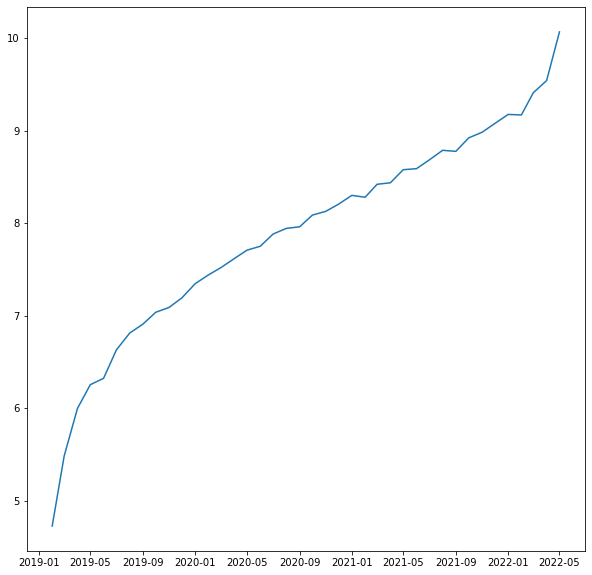

In [ ]:
# Plot dalam bentuk visualisasi line chart dengan menggunakan function numpy np.log
plt.figure(figsize=(10,10))
data_log=np.log(data) 
plt.plot(data_log)

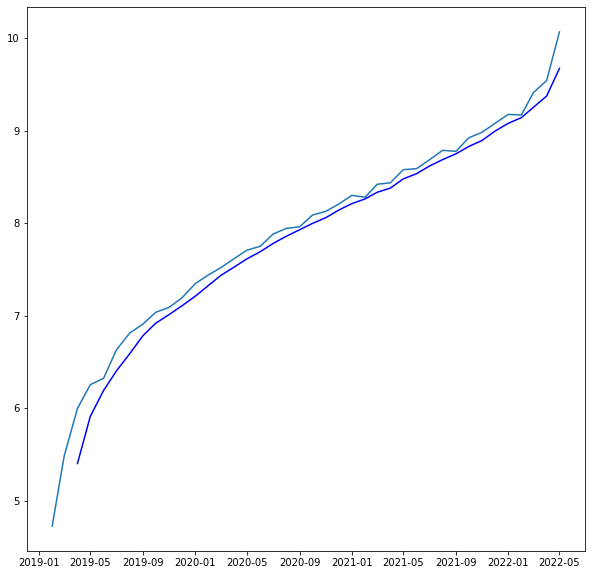

In [ ]:
# Cek secara visual kembali dengan plot data_log dengan rolling window mean dan std. deviation
plt.figure(figsize=(10,10))

MAvg=data_log.rolling(window=3).mean() 
MStd=data_log.rolling(window=3).std()

plt.plot(data_log)
plt.plot(MAvg, color='blue')
#plt.plot(MStd, color='red')

In [ ]:
# Hitung difference dari data_log dengan MAvg
data_log_diff=data_log-MAvg

# Tampilkan 12 baris teratas dari data_log_diff
data_log_diff.head(12)

,total_sales
month,
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,0.595229
2019-05-01,0.342589
2019-06-01,0.131344
2019-07-01,0.227965
2019-08-01,0.223509
2019-09-01,0.125352
2019-10-01,0.117791


In [ ]:
# Efek dari rolling di atas, maka akan ada value NaN, sehingga kita bisa lakukan dropna()
data_log_diff=data_log_diff.dropna() 
data_log_diff.head()

,total_sales
month,
2019-04-01,0.595229
2019-05-01,0.342589
2019-06-01,0.131344
2019-07-01,0.227965
2019-08-01,0.223509


In [ ]:
# Buat function stationarity untuk menampilkan multiple line chart dari actual, rolling mean, dan rolling std.deviasi
# yang juga berisikan hasil tes dari Dickey-Fuller

def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(10,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['total_sales'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

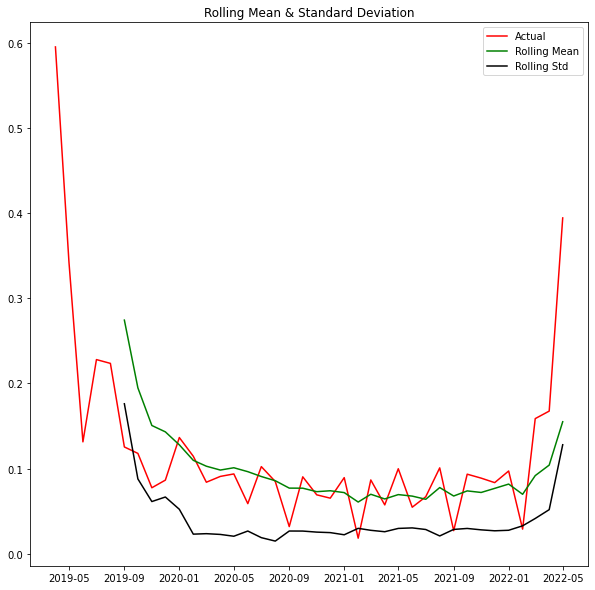

Dickey-Fuller Test: 
Test Statistic           1.944603
p-value                  0.998596
Lags Used                7.000000
No. of Obs              30.000000
Critical Value (1%)     -3.669920
Critical Value (5%)     -2.964071
Critical Value (10%)    -2.621171
dtype: float64


In [ ]:
# panggil function dan terapkan pada data_log_diff
stationarity(data_log_diff)

Karena p-value > 0.05 maka masih belum stasioner, maka kita dapat mencoba lagi dengan menggunakan Exponentially Weighted Moving Average (function `ewm`), karena melalui EWM kita dapat memberikan lebih banyak bobot kepada observasi terbaru, dengan kata lain dia akan memberikan bobot lebih sedikit terhadap data yang semakin jauh dari waktu kini, sehingga dia dapat menangkap tren terkini secara lebih cepat 

> **Insights:**

Karena p-value > 0.05 sehingga masih belum stasioner , maka akan dilanjutkan Shift test Check Stationarity

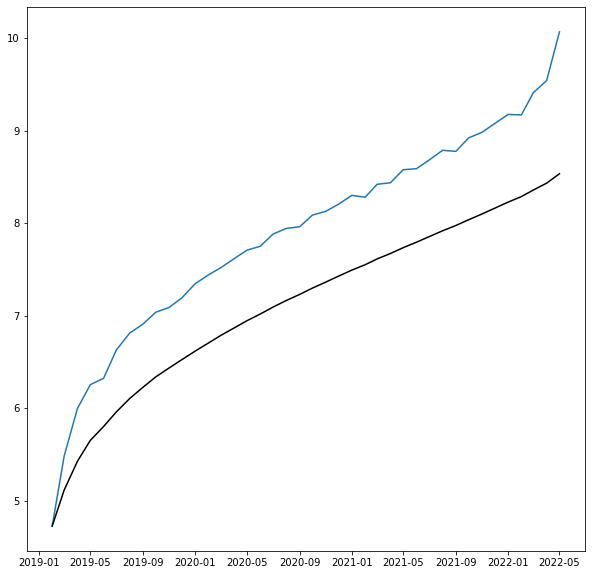

In [ ]:
# Visualisasikan ke dalam bentuk chart 
plt.figure(figsize=(10,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean() 

plt.plot(data_log)
plt.plot(exp_data, color='black')

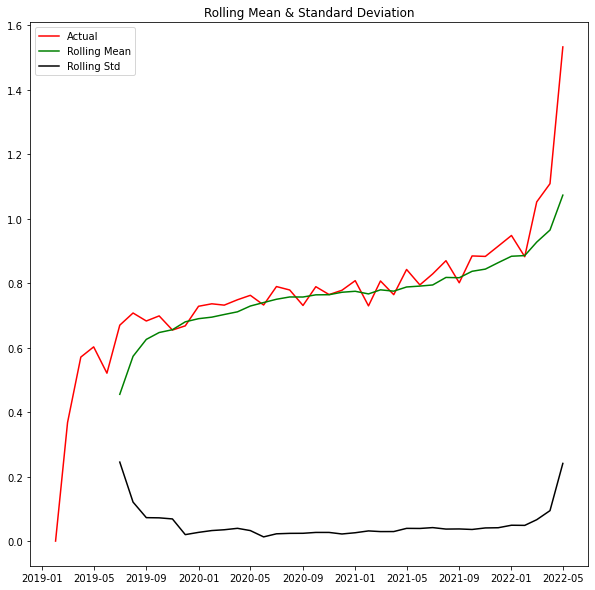

Dickey-Fuller Test: 
Test Statistic           2.198750
p-value                  0.998881
Lags Used                7.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


In [ ]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff = data_log-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

> **Insights:**
Tampak jelas bahwa p-value masih lebih besar dari 0.05 sehingga time series ini masih non stationer, maka akan dilakukan pengecekan pada data shift apakah time seriesnya juga masih non stationer

#### 4.4 Stationarity Check - Shift test

#### 4.4 Stationarity Check - Shift test

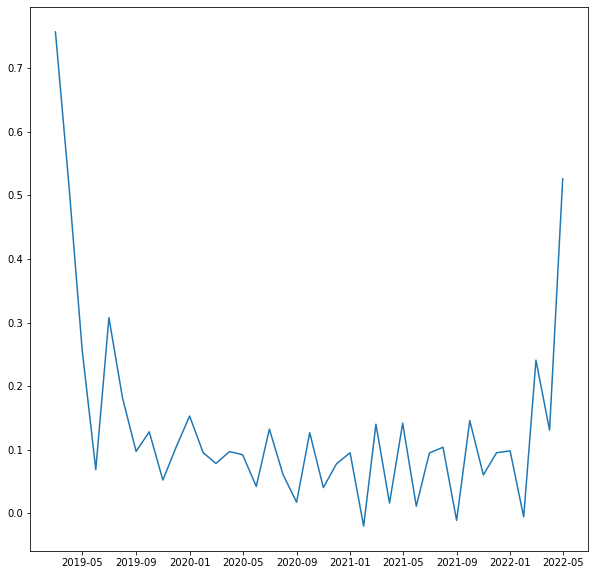

In [ ]:
# Buat format ukuran chart
plt.figure(figsize=(10,10))

# Terapkan shift terhadap data yang telah diterapkan transformasi log di cell sebelumnya
data_shift=data_log-data_log.shift() 

# Tampilkan chart
plt.plot(data_shift)

In [ ]:
# Check missing value
data_shift.isna().sum()

total_sales    1
dtype: int64

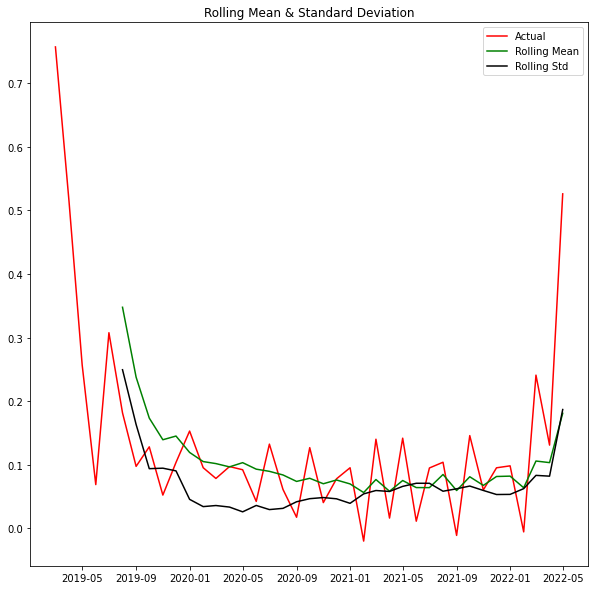

Dickey-Fuller Test: 
Test Statistic           1.845677
p-value                  0.998435
Lags Used                7.000000
No. of Obs              31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
dtype: float64


In [ ]:
# Lakukan dropna 
data_shift=data_shift.dropna()

# Panggil function stationarity dan terapkan pada data_shift yang sudah dibersihkan dari NA value
stationarity(data_shift)

Dari data_shift di atas, hasil ADF test menunjukkan bahwa p-value > 0.05 sehingga kita (failed to reject) gagal untuk menolak null hypothesis yang mengindikasikan bahwa series ini tidak stasioner.

Test statistic yang lebih besar dari Critical value pd 1% dan 5% juga menunjukkan hal demikian. Sehingga dalam observasi ini kita menyimpulkan bahwa series ini variant to time shift (mengalami perubahan pada pergeseran waktu)

#### 4.5 Decomposition and Autocorrelation Function

* Forecasting menggunakan data historikal dimana diurutkan dengan waktu, sehingga goal dari time series model yaitu untuk menemukan waktu dengan trend, seasonality, dan autocorrelation (correlation over time) lalu diformulasikan menjadi sebuah model.

* Teknik Decomposition ini digunakan untuk split data time series menjadi beberapa komponen yaitu trend, seasonality, dan noise (residual) components. 

* Setiap komponen dapat digunakan untuk menunjukkan pola (pattern) yang ada di dalam tiap kategori agar dapat menentukan apakah model Additive atau Multiplicative.

  * **Seasonality**: describes the periodic signal in your time series.
  * **Trend**: describes whether the time series is decreasing, constant, or increasing over time.
  * **Noise**: describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.


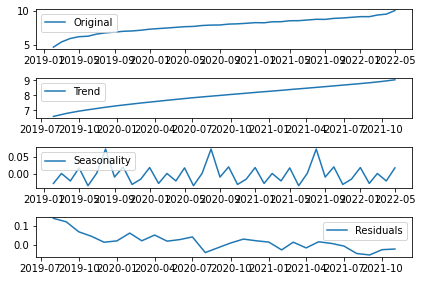

In [ ]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar 
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> **Insights:**

* Dari proses seasonal decompose, maka akan terbagi 
menjadi grafik original, trend (dalam hal ini dengan pola menaik), Seasonality (pola berulang yang terjadi dari tahun ke tahun), dan residuals (seberapa jauh titik data dari garis regresi).

* Dapat dilihat bahwa trend dari time series total_sales adalah semakin menaik, dan seasonality mengikuti pola. 

In [ ]:
# Tampilkan nilai dari tiap kategori dari 12 baris teratas
print("Trend \n",trend.head(12), '\n') # \n untuk menambahkan baris di akhir
print("Seasonal \n",seasonal.head(12), '\n')
print("Residual \n",residual.head(12), '\n')

Trend 
             total_sales
month                  
2019-02-01          NaN
2019-03-01          NaN
2019-04-01          NaN
2019-05-01          NaN
2019-06-01          NaN
2019-07-01          NaN
2019-08-01     6.598034
2019-09-01     6.795996
2019-10-01     6.948279
2019-11-01     7.076314
2019-12-01     7.196379
2020-01-01     7.308035 

Seasonal 
             total_sales
month                  
2019-02-01    -0.027377
2019-03-01     0.001718
2019-04-01    -0.019990
2019-05-01     0.018142
2019-06-01    -0.033966
2019-07-01     0.002197
2019-08-01     0.073122
2019-09-01    -0.008749
2019-10-01     0.020992
2019-11-01    -0.030308
2019-12-01    -0.014894
2020-01-01     0.019112 

Residual 
             total_sales
month                  
2019-02-01          NaN
2019-03-01          NaN
2019-04-01          NaN
2019-05-01          NaN
2019-06-01          NaN
2019-07-01          NaN
2019-08-01     0.142288
2019-09-01     0.123504
2019-10-01     0.069512
2019-11-01     0.044903
2019-1

> **Insights:**

Dari data residual, kita dapat melihat banyak NA value, maka kita lakukan dropna

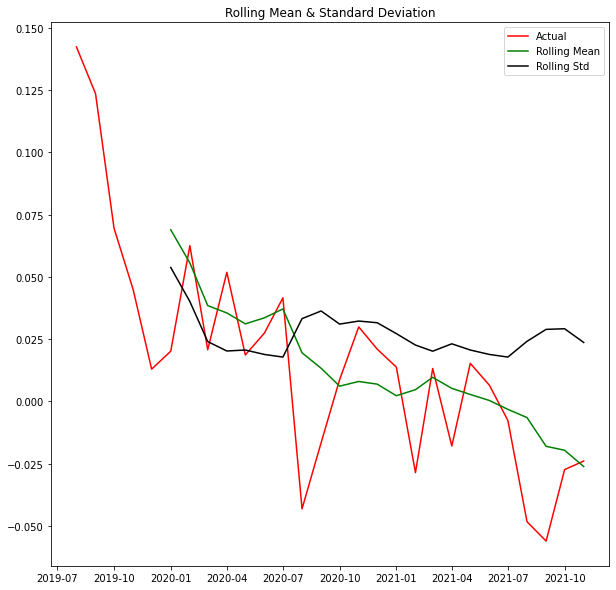

Dickey-Fuller Test: 
Test Statistic          -3.202927
p-value                  0.019816
Lags Used                0.000000
No. of Obs              27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


In [ ]:
# assign variable baru decomp_data dengan variabel residual di atas
decomp_data=residual

# terapkan function dropna
decomp_data=decomp_data.dropna()

# Panggil function stationarity dan terapkan pada decomp data yang tanpa NA value
stationarity(decomp_data)

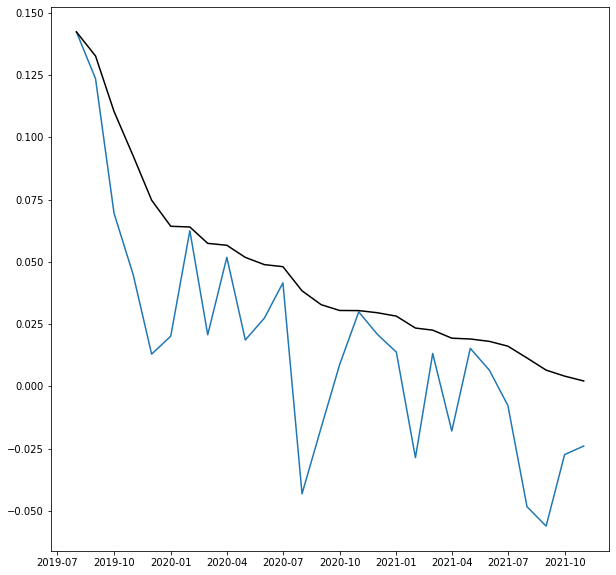

In [ ]:
# Visualisasikan ke dalam bentuk chart 
plt.figure(figsize=(10,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=decomp_data.ewm(halflife=12, min_periods=0, adjust=True).mean() 

plt.plot(decomp_data)
plt.plot(exp_data, color='black')

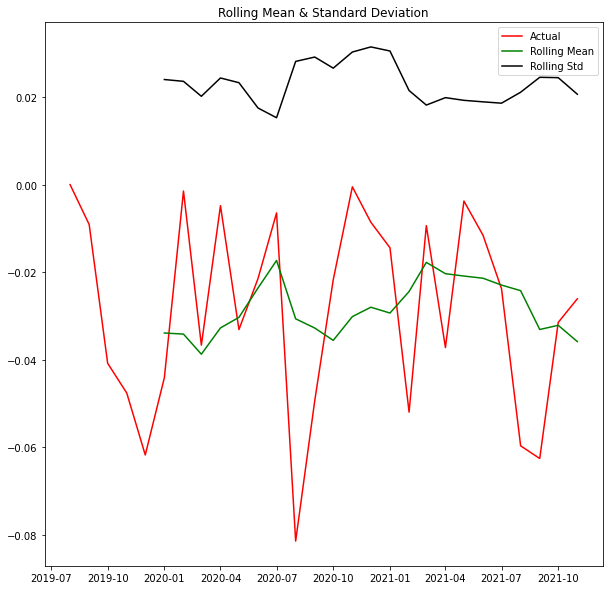

Dickey-Fuller Test: 
Test Statistic          -4.443724
p-value                  0.000248
Lags Used                0.000000
No. of Obs              27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


In [ ]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff=decomp_data-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

In [ ]:
decomp_data = exp_data_diff

> **Insights:**

Dari komponen data residual, hasil ADF test menunjukkan bahwa bahwa nilai Test statistic yg jauh lebih kecil daripada critical value pd berbagai tingkat keyakinan. Dan p-value yang jauh lebih kecil dari 0.05, kita dapat menyatakan bahwa series ini cukup kuat stasioner.

Text(0.5, 1.0, 'Partial Autocorrelation Function / PACF')

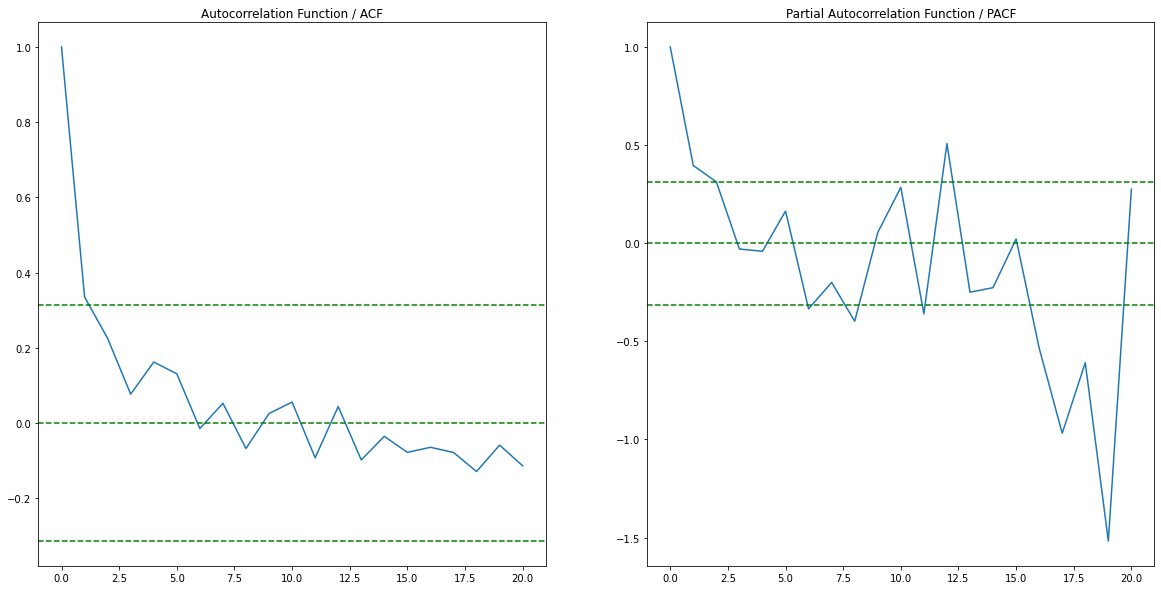

In [ ]:
# dari module time series analysis, import function acf dan pacf
# ACF = Auto Correlation Function
# PACF = Partial Auto Correlation Function
from statsmodels.tsa.stattools import acf, pacf 

# terapkan function acf dan pcf pada data_shift yang sudah dibuat
lag_acf=acf(data_shift, nlags=20)
lag_pacf=pacf(data_shift, nlags=20, method='ols')

# Format grafik dan visualisasikan ACF
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = 0.16
plt.title('Autocorrelation Function / ACF')

# Format grafik dan visualisasikan PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = 0.16
plt.title('Partial Autocorrelation Function / PACF')

> **Interpretation:**

* Fungsi ACF dan PCF membantu kita dengan melakukan plot korelasi antara time series dan lag series tsb dengan 95% tingkat keyakinan ditandai dengan garis hijau putus-putus. 

* Jika nilai autocorrelation memotong/melewati garis putus-putus tersebut dapat diartikan bahwa specific lag tsb berkorelasi secara signifikan dengan time series yang ada. 

* Dari grafik di atas terlihat bahwa grafik time series (berwarna biru) berpotongan dengan grafik shift time series (dlm hal ini dengan lag=20) baik pada batas atas maupun bawah, sehingga dapat dikatakan bahwa grafik time series ini mengalami efek auto correlation. 

###5 Model Development

> Pada Model Development, kita akan mencoba menerapkan 2 model time series yaitu:
SARIMAX (pada dasarnya ini adalah ARIMA, yang memang spesifik untuk menghadapi seasonal effect seperti yg dialami oleh data yg sedang kita olah ini)


* Pisahkan data time series menjadi train dan test data




In [ ]:
train = data[0:int(len(data)*0.90)]   #train data sebesar 90%
test = data[int(len(data)*0.90):]     #test data sebesar 10% 

#### **SARIMAX**

****

* **SARIMAX** (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) adalah versi update dari model ARIMA, dapat dikatakan bahwa SARIMAX model seasonal equivalent seperti halnya SARIMA dan Auto ARIMA, yang mana model ini dapat juga memperhitungkan efek eksternal.

* Karena ARIMA tidak mendukung seasonality, maka beda dengan SARIMAX yang dapat digunakan pada data set yang memiliki siklus musiman (*seasonality*).

* terdiri dari 3 parameter yaitu (p, d, dan q)
  * p is the order of the AR term
  * q is the order of the MA term
  * d is the number of differencing required to make the time series stationary

In [ ]:
data.head()

,total_sales
month,
2019-02-01,113
2019-03-01,241
2019-04-01,403
2019-05-01,521
2019-06-01,558


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['total_sales'])

In [ ]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 0, 0, 12)12 model - AIC:-107.17498398619291


In [ ]:
# tampilkan hasil dari SARIMAX
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(1,1,0),
                                seasonal_order=(1,0,0,12),
                                enforce_stationarity=True)

best_results = mod.fit()

print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9371      0.036     26.041      0.000       0.867       1.008
ar.S.L12       0.4625      0.219      2.115      0.034       0.034       0.891
sigma2         0.0020      0.001      3.003      0.003       0.001       0.003


In [ ]:
# Terapkan function get_prediction() pada best_results
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2019-02-01'), dynamic=True, full_results=True)
pred_dynamic

In [ ]:
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci 

,lower total_sales,upper total_sales
2019-02-01,-1959.964016,1959.964016
2019-03-01,-1959.964106,1959.964106
2019-04-01,-1959.964254,1959.964254
2019-05-01,-1959.964458,1959.964458
2019-06-01,-1959.964715,1959.964715
2019-07-01,-1959.965024,1959.965024
2019-08-01,-1959.965384,1959.965384
2019-09-01,-1959.965793,1959.965793
2019-10-01,-1959.966252,1959.966252
2019-11-01,-1959.966758,1959.966758


In [ ]:
pred99 = best_results.get_forecast(steps=20, alpha=0.1)
pred99

In [ ]:
# Extract the predicted and true values of our time series
# sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['total_sales_Forecast'] = np.power(10, pred99.predicted_mean)

In [ ]:
testCopy

,total_sales,total_sales_Forecast
month,,
2022-02-01,9616,10080.148493
2022-03-01,12235,11278.086178
2022-04-01,13944,11878.931484
2022-05-01,23599,13223.940313


In [ ]:
testCopy=testCopy.dropna()

In [ ]:
testCopy

,total_sales,total_sales_Forecast
month,,
2022-02-01,9616,10080.148493
2022-03-01,12235,11278.086178
2022-04-01,13944,11878.931484
2022-05-01,23599,13223.940313


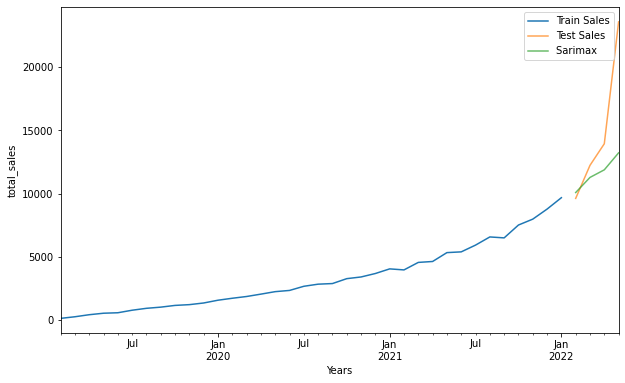

In [ ]:
# visualisasikan dari antara train, test, dan hasil forecast

axis = train['total_sales'].plot(label='Train Sales', figsize=(10, 6))
testCopy['total_sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['total_sales_Forecast'].plot(ax=axis, label='Sarimax ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('total_sales')
plt.legend(loc='best')
plt.show()
plt.close()

###6 Plot forecast with Confidence band

> Tahap ini kita akan melakukan visualisasi nilai prediksi beserta interval keyakinan

**Forecast Total Sales using the best fit model SARIMAX**

In [ ]:
# Get forecast 20 steps (1 years) ahead in future
n_steps = 20
pred_uc_99 = best_results.get_forecast(steps=20, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=20, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [ ]:
#prediksi 1 tahun mendatang menggunkan sarimax
n_steps = 20
idx = pd.date_range(data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2022-05-01,10080.148493,8248.936077,1.231788e+04,8248.936077,1.231788e+04
2022-06-01,11278.086178,7284.955457,1.745999e+04,7284.955457,1.745999e+04
2022-07-01,11878.931484,5817.828330,2.425459e+04,5817.828330,2.425459e+04
2022-08-01,13223.940313,4765.769317,3.669347e+04,4765.769317,3.669347e+04
2022-09-01,13821.662715,3582.497340,5.332547e+04,3582.497340,5.332547e+04
2022-10-01,14980.174410,2743.483385,8.179588e+04,2743.483385,8.179588e+04
2022-11-01,16265.978692,2076.083940,1.274429e+05,2076.083940,1.274429e+05
2022-12-01,16710.092781,1470.590894,1.898742e+05,1470.590894,1.898742e+05
2023-01-01,18422.534572,1108.833313,3.060783e+05,1108.833313,3.060783e+05
2023-02-01,19485.896473,797.232410,4.762729e+05,797.232410,4.762729e+05


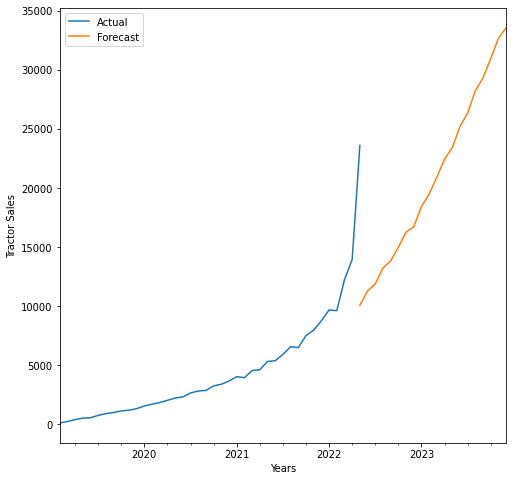

In [ ]:
# plot the forecast along with the confidence band
axis = data['total_sales'].plot(label='Actual', figsize=(8,8))
fc_all['forecast'].plot(ax=axis, label='Forecast')
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

### 7 Model Evaluation

>Sekarang kita akan melakukan validasi dan evaluasi terhadap model yang telah kita buat

**Plot ACF and PACF for residuals of SARIMAX model**

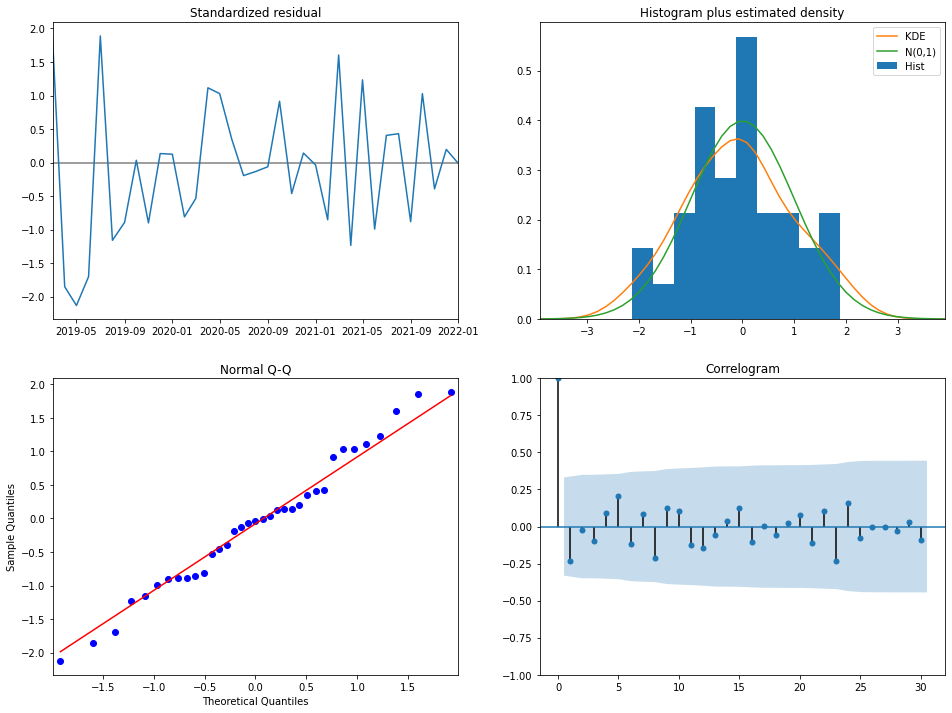

In [ ]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

* Grafik standardized residuals menunjukkan bahwa sebagian besar titik sudah berada pada y=0 yang berarti bahwa prediksi tidak menyimpang jauh dari data aktual.

* Grafik histogram sudah menunjukkan kecenderungan normal (garis hijau adalah grafik garis dari ujung histogram) dan KDE menunjukkan grafik kecocokan prediksi.

* Q–Q plot adalah probability plot, yang mana digunakan untuk mengecek apakah data kita berada pada garis normal. 

* Correlogram, juga dikenal sebagai Auto Correlation Function (ACF) plot, meruapakan cara grafis untuk memperlihatkan korelasi serial pada data yang tidak selalu konstan dalam kurun waktu tertentu. Correlogram akan memperlihatkan gambaran apakah terdapat auto-correlation diantara pasangan data pada kurun waktu yang berbeda.

* Model SARIMAX

In [ ]:
# Import module metrics dan panggil functionnya
from sklearn.metrics import mean_absolute_percentage_error

y_true = testCopy['total_sales']
y_pred = testCopy['total_sales_Forecast']

print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')

The Mean Absolute Percentage Error of our forecasts is  0.179 %
